In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [3]:
warnings.filterwarnings('ignore')

data_path = r'E:\DijiKent\USAHouseDataAnalysis\Data\HouseDataNew.csv'
data = pd.read_csv(data_path)

missing_data = data.isnull().sum()
missing_percentage = (missing_data / len(data)) * 100

missing_summary = pd.DataFrame({
    'Missing Values': missing_data,
    'Percentage': missing_percentage
}).sort_values(by='Missing Values', ascending=False)

print("Missing Data Summary:")
print(missing_summary)

Missing Data Summary:
                   Missing Values  Percentage
prev_sold_date             215379   65.681350
acre_lot                    66630   20.319290
lot_size_category           66630   20.319290
bed_bath_ratio              64718   19.736212
bed                         63412   19.337938
bath                        62353   19.014989
price_per_sqft              60827   18.549624
house_size                  60827   18.549624
zip_code                      197    0.060077
city                           52    0.015858
state                           0    0.000000
status                          0    0.000000
price                           0    0.000000
price_category                  0    0.000000


In [4]:
numerical_cols = ['bed', 'bath', 'acre_lot', 'house_size', 'price_per_sqft', 'bed_bath_ratio']
data[numerical_cols] = data[numerical_cols].fillna(data[numerical_cols].median())

columns_to_drop = ['prev_sold_date', 'lot_size_category']
data = data.drop(columns=columns_to_drop)

categorical_cols = ['city', 'zip_code']
data[categorical_cols] = data[categorical_cols].fillna(data[categorical_cols].mode().iloc[0])

missing_data_after = data.isnull().sum()
missing_percentage_after = (missing_data_after / len(data)) * 100

missing_summary_after = pd.DataFrame({
    'Missing Values': missing_data_after,
    'Percentage': missing_percentage_after
}).sort_values(by='Missing Values', ascending=False)

print("Updated Missing Data Summary:")
print(missing_summary_after)


Updated Missing Data Summary:
                Missing Values  Percentage
status                       0         0.0
bed                          0         0.0
bath                         0         0.0
acre_lot                     0         0.0
city                         0         0.0
state                        0         0.0
zip_code                     0         0.0
house_size                   0         0.0
price                        0         0.0
price_per_sqft               0         0.0
price_category               0         0.0
bed_bath_ratio               0         0.0


In [5]:
filtered_data = data[(data['price'] < 2000000) & (data['house_size'] < 10000)]

features = ['bed', 'bath', 'acre_lot', 'house_size', 'price_per_sqft', 'bed_bath_ratio']
target = 'price'
X = filtered_data[features]
y = filtered_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 200}


In [7]:
y_pred = best_rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)

importances = best_rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

Mean Absolute Error (MAE): 24485.568574227447
Mean Squared Error (MSE): 9927977561.887705
Root Mean Squared Error (RMSE): 99639.23705994393


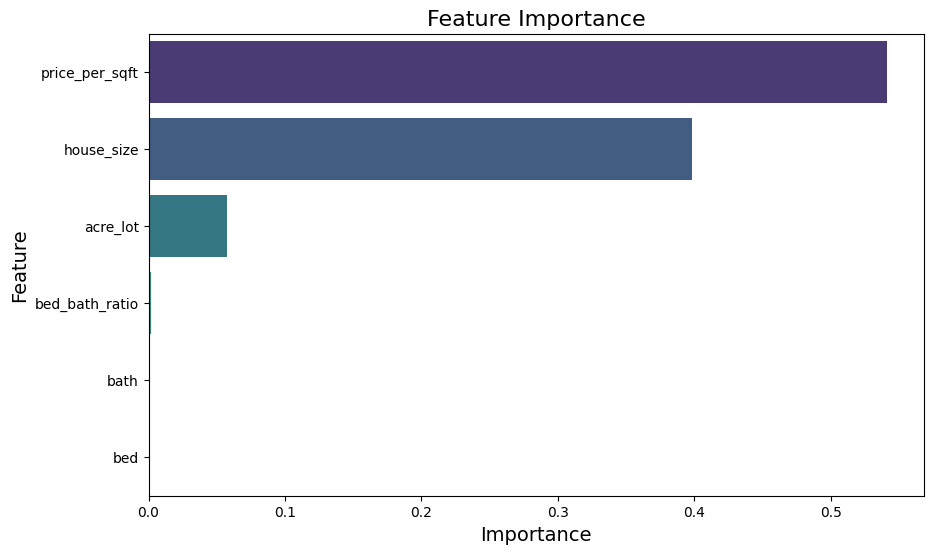

In [8]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.show()

In [11]:
import joblib
import os

os.makedirs('model', exist_ok=True)

model_save_path = 'model/best_rf_model.pkl'
joblib.dump(best_rf, model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to model/best_rf_model.pkl


In [12]:
loaded_model = joblib.load(model_save_path)

new_data = pd.DataFrame({
    'bed': [3],
    'bath': [2],
    'acre_lot': [0.5],
    'house_size': [1500],
    'price_per_sqft': [200],
    'bed_bath_ratio': [1.5]
})
new_prediction = loaded_model.predict(new_data)
print("Predicted Price for New Data:", new_prediction[0])


Predicted Price for New Data: 299954.925


Batch Predictions:
   bed  bath  acre_lot  house_size  price_per_sqft  bed_bath_ratio  \
0    4     3  1.421398        1624      299.358332        1.451460   
1    1     1  1.848737        2158      250.683328        1.971361   
2    4     2  0.750526        1377      265.712281        1.895984   
3    3     1  1.384563        1442      239.376299        1.769350   
4    1     2  1.041853        2005      195.024733        1.199825   
5    3     1  1.708329         995      125.380567        0.846386   
6    1     2  0.989971         882      251.921116        1.862734   
7    2     2  1.375847        2092      247.300782        1.869126   
8    2     2  0.303924        2041      234.749867        0.619878   
9    1     1  1.064468        1512      254.685690        0.899545   

   Predicted Price  
0       483873.000  
1       546598.500  
2       362131.000  
3       345854.000  
4       393060.995  
5       124688.000  
6       217624.000  
7       520682.500  
8       479581.000  


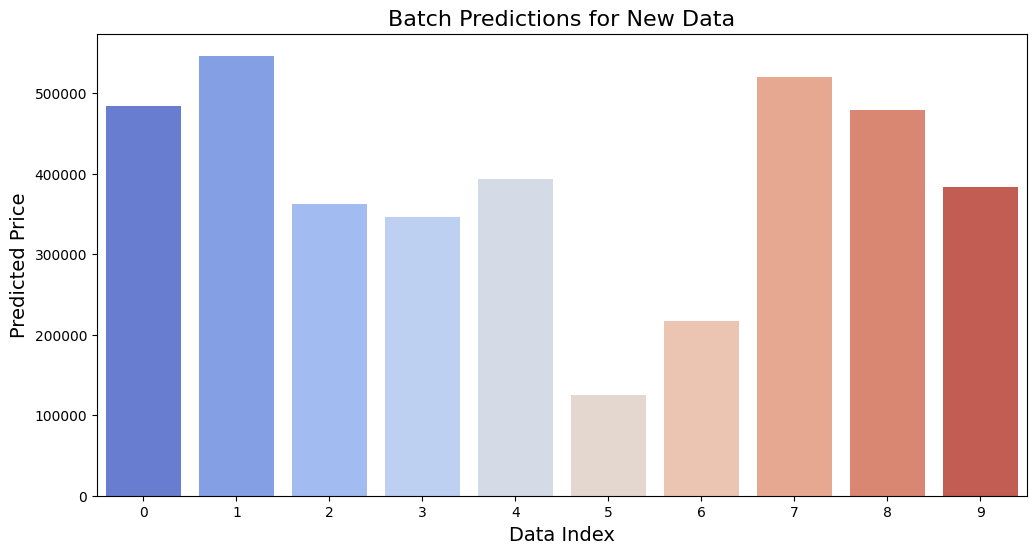

In [13]:
batch_data = pd.DataFrame({
    'bed': np.random.randint(1, 5, 10),
    'bath': np.random.randint(1, 4, 10),
    'acre_lot': np.random.uniform(0.1, 2, 10),
    'house_size': np.random.randint(800, 3000, 10),
    'price_per_sqft': np.random.uniform(100, 300, 10),
    'bed_bath_ratio': np.random.uniform(0.5, 2.5, 10)
})

batch_predictions = loaded_model.predict(batch_data)
batch_data['Predicted Price'] = batch_predictions

print("Batch Predictions:")
print(batch_data)

plt.figure(figsize=(12, 6))
sns.barplot(x=batch_data.index, y=batch_data['Predicted Price'], palette='coolwarm')
plt.title('Batch Predictions for New Data', fontsize=16)
plt.xlabel('Data Index', fontsize=14)
plt.ylabel('Predicted Price', fontsize=14)
plt.show()

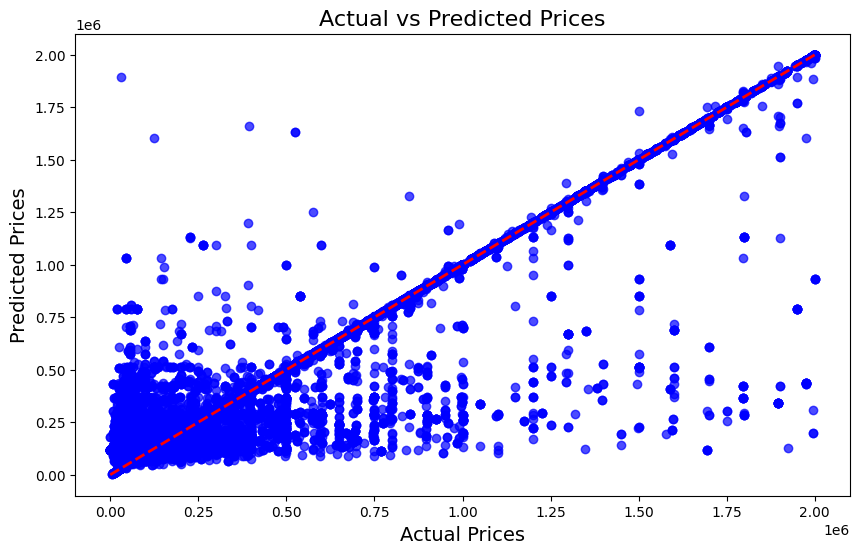

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.title('Actual vs Predicted Prices', fontsize=16)
plt.xlabel('Actual Prices', fontsize=14)
plt.ylabel('Predicted Prices', fontsize=14)
plt.show()

Comparison of Actual and Predicted Prices:
   bed  bath  acre_lot  house_size  price_per_sqft  bed_bath_ratio  \
0    2     1       0.3        1200             150            2.00   
1    4     3       0.7        2500             220            1.33   
2    3     2       0.5        1800             180            1.50   

   actual_price  predicted_price  
0        250000       182568.585  
1        550000       549769.855  
2        360000       323791.500  


<Figure size 1000x600 with 0 Axes>

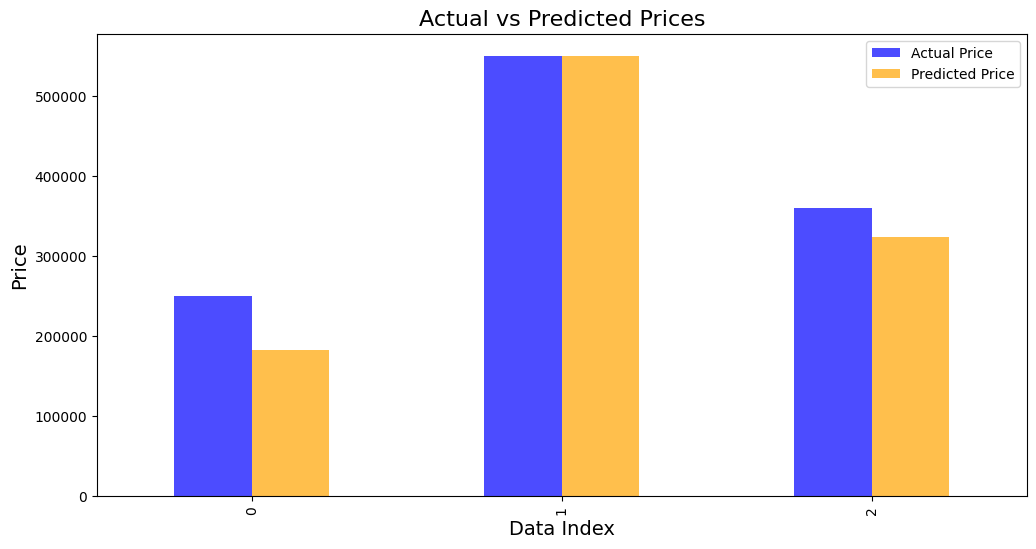

In [27]:
comparison_data = pd.DataFrame({
    'bed': [2, 4, 3],
    'bath': [1, 3, 2],
    'acre_lot': [0.3, 0.7, 0.5],
    'house_size': [1200, 2500, 1800],
    'price_per_sqft': [150, 220, 180],
    'bed_bath_ratio': [2, 1.33, 1.5],
    'actual_price': [210000, 550000, 360000]
})

comparison_predictions = loaded_model.predict(comparison_data.drop(columns=['actual_price']))
comparison_data['predicted_price'] = comparison_predictions

print("Comparison of Actual and Predicted Prices:")
print(comparison_data)

plt.figure(figsize=(10, 6))
comparison_data.set_index(comparison_data.index, inplace=True)
comparison_data[['actual_price', 'predicted_price']].plot(kind='bar', figsize=(12, 6),
                     color=['blue', 'orange'], alpha=0.7)
plt.title('Actual vs Predicted Prices', fontsize=16)
plt.xlabel('Data Index', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend(['Actual Price', 'Predicted Price'])
plt.show()